# <center> 5. Recommendation systems

- Recommendation system functions;
- Comparison of User-based and Item-based approaches.

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy import spatial

In [15]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

In [16]:
df = pd.read_csv('data/u.data', sep='\t', header=None)
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

df = df.pivot(index='user_id', columns='item_id', values='rating')
df.head(3)

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Functions

DFCarrier will carry dataframe, and for predprocessing of it.

Recommendator will inherit DFCarrier methods and will manage main recomendation functions.

In [17]:
class DFCarrier():
    """
    Gets raw dataframe where Rows are Users, Columns are Items,
    and values a_{x, k} is user's x rating of item k.
    """
    def __init__(self, data_frame: pd.DataFrame, c_constant=50, neighbours_max=10):
        self.df = data_frame
        # clear rows with only one unique entrie as anomaly
        self.df = self.df[self.df.apply(lambda t: len(t.dropna().unique()), axis=1) > 1]
        self.c = c_constant
        self.maxN = neighbours_max
        
        self.df_centered = None
        self.df_mu_std = None
        
        self.get_centered_df()
        self.get_mu_std()
        
        self.users = self.df_centered.index
        self.items = self.df_centered.columns
    
    def get_centered_df(self) -> None:
        # make user ratings centered
        self.df_centered = self.df.apply(lambda x: x - x.mean(), axis=1)
        pass
    
    def get_mu_std(self) -> None:
        self.df_mu_std = pd.DataFrame({'mean': self.df.apply(lambda x: x.mean(), axis=1),
                                       'std': self.df.apply(lambda x: x.std(), axis=1)})
        pass

In [18]:
class Recommendator(DFCarrier):
    """
    Gives recommendations in different ways.
    """
    def similarity_ubcf(self, u1_ind, u2_ind) -> float:    
        u1 = self.df_centered.loc[u1_ind]
        u2 = self.df_centered.loc[u2_ind]
        mask = np.invert(u1.isna() | u2.isna())
        if mask.sum() > 0:
            u1 = u1[mask]
            u2 = u2[mask]
            c = min(1, sum(mask) / self.c)
            return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
        else:
            return 0
    
    def get_nearest_neighbors_ubcf(self, u_ind, n=None) -> list:
        if n == None:
            n = self.maxN
        vec_ = [(user, self.similarity_ubcf(u_ind, user)) for user in self.users if user != u_ind]
        return sorted(vec_, key=(lambda x: -x[1]))[:n]
    
    def user_based_cf(self, u_ind, n=None) -> pd.Series:
        if n == None:
            n = self.maxN
        # nearest neighbours
        nn, nn_dist = list(map(np.array, zip(*self.get_nearest_neighbors_ubcf(u_ind, n=n))))
        nn_std = self.df_mu_std.loc[nn]['std']
        # mean score among nn
        dist_sigma_centered_df = self.df_centered.loc[nn].apply(lambda col:
                                                       sum(
                                                           (
                                                                 col
                                                               * nn_dist
                                                               / nn_std
                                                           ).fillna(0)
                                                       )
                                                       / sum(nn_dist[col.notna()]) if sum(col.notna() >= 1) else np.nan
                                                      )
        return self.df_mu_std.loc[u_ind]['mean'] + self.df_mu_std.loc[u_ind]['std'] * dist_sigma_centered_df
    
    def similarity_ibcf(self, i1_ind, i2_ind) -> float:    
        i1 = self.df.loc[:, i1_ind]
        i2 = self.df.loc[:, i2_ind]
        mask = np.invert(i1.isna() | i2.isna())
        if mask.sum() > 0:
            i1 = (i1 - self.df_mu_std['mean'])[mask]
            i2 = (i2 - self.df_mu_std['mean'])[mask]
            return np.dot(i1, i2) / np.linalg.norm(i1) / np.linalg.norm(i2)
        else:
            return 0

    def get_nearest_neighbors_ibcf(self, i_ind, n=None) -> list:
        if n == None:
            n = self.maxN
        vec_ = [(item, self.similarity_ibcf(i_ind, item)) for item in self.items if item != i_ind]
        return sorted(vec_, key=(lambda x: -x[1]))[:n]

    def item_based_cf(self, i_ind, n=None) -> pd.Series:
        if n == None:
            n = self.maxN
        # nearest neighbours
        nn, nn_dist = list(map(np.array, zip(*self.get_nearest_neighbors_ibcf(i_ind, n=n))))
        # mean score among
        return self.df.loc[:, nn].apply(lambda row: row.dropna().mean() if row.dropna().mean() > 0 else np.nan, axis=1)


In [19]:
rater = Recommendator(df, neighbours_max=100)

In [20]:
rater.similarity_ubcf(1, 2)
rater.similarity_ubcf(1, 1)
rater.similarity_ibcf(1, 2)
rater.similarity_ibcf(1, 1)

0.1299134830082074

1.0

-0.1383777336500316

1.0

## RMSE

In [21]:
u = 1
ub_1 = rater.user_based_cf(u)
mask = ub_1.notna() & df.loc[u].notna()
mean_squared_error(ub_1[mask], df.loc[u][mask])

0.7208518849189018

In [22]:
i = 1
ib_1 = rater.item_based_cf(i)
mask = ib_1.notna() & df.loc[:, i].notna()
mean_squared_error(ib_1[mask], df.loc[:, i][mask])

0.6656881241274473

In [23]:
true_vector = np.array([])
predict_vector = np.array([])
for u in tqdm(df.index[:10]):
    ub = rater.user_based_cf(u)
    mask = ub.notna() & df.loc[u].notna()
    true_vector = np.hstack([true_vector, ub[mask]])
    predict_vector = np.hstack([predict_vector, df.loc[u][mask]])
mean_squared_error(true_vector, predict_vector)

 30%|████████████████████████▉                                                          | 3/10 [00:07<00:17,  2.55s/it]<ipython-input-18-97a229c538c2>:13: RuntimeWarning: invalid value encountered in double_scalars
  return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
<ipython-input-18-97a229c538c2>:31: RuntimeWarning: invalid value encountered in double_scalars
  sum(
 40%|█████████████████████████████████▏                                                 | 4/10 [00:10<00:14,  2.49s/it]<ipython-input-18-97a229c538c2>:13: RuntimeWarning: invalid value encountered in double_scalars
  return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:17<00:07,  2.49s/it]<ipython-input-18-97a229c538c2>:13: RuntimeWarning: invalid value encountered in double_scalars
  return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
 80%|█████████████████████████████████████

0.7195612756509975

function works slowly, so we will check only on 10 samples.

In [24]:
true_vector = np.array([])
predict_vector = np.array([])
for i in tqdm(df.columns[:10]):
    ib = rater.item_based_cf(i)
    mask = ib.notna() & df.loc[:, i].notna()
    true_vector = np.hstack([true_vector, ib[mask]])
    predict_vector = np.hstack([predict_vector, df.loc[:, i][mask]])
mean_squared_error(true_vector, predict_vector)

 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:13,  2.33s/it]<ipython-input-18-97a229c538c2>:49: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(i1, i2) / np.linalg.norm(i1) / np.linalg.norm(i2)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


0.5833780598920654

## Hyperparams

In [526]:
users = df.index
am = [(df.loc[x] * df.loc[y]).notna().sum() for x in users for y in users]

<AxesSubplot:ylabel='Frequency'>

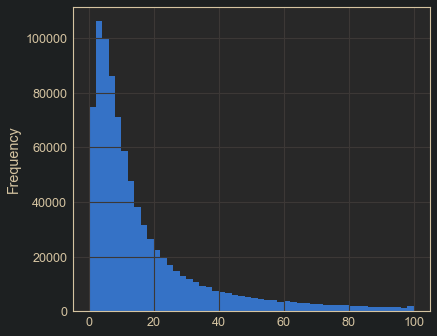

In [538]:
amS = pd.Series(am)
amS[amS <= 100].plot.hist(bins=50)

Main part of pairs has ~< 20 of intersections, so $K \approx 20$ is enough.

In [25]:
true_vector = np.array([])
predict_vector = np.array([])
for u in tqdm(df.index[:10]):
    ub = rater.user_based_cf(u, 20)
    mask = ub.notna() & df.loc[u].notna()
    true_vector = np.hstack([true_vector, ub[mask]])
    predict_vector = np.hstack([predict_vector, df.loc[u][mask]])
mean_squared_error(true_vector, predict_vector)

 30%|████████████████████████▉                                                          | 3/10 [00:07<00:16,  2.38s/it]<ipython-input-18-97a229c538c2>:13: RuntimeWarning: invalid value encountered in double_scalars
  return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:13,  2.28s/it]<ipython-input-18-97a229c538c2>:13: RuntimeWarning: invalid value encountered in double_scalars
  return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:15<00:06,  2.24s/it]<ipython-input-18-97a229c538c2>:13: RuntimeWarning: invalid value encountered in double_scalars
  return c * np.dot(u1, u2) / np.linalg.norm(u1) / np.linalg.norm(u2)
 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:18<00:04,  2.32s/it]<ipython-input-18-97a229c5

0.7494925480051209

In [26]:
true_vector = np.array([])
predict_vector = np.array([])
for i in tqdm(df.columns[:10]):
    ib = rater.item_based_cf(i, 20)
    mask = ib.notna() & df.loc[:, i].notna()
    true_vector = np.hstack([true_vector, ib[mask]])
    predict_vector = np.hstack([predict_vector, df.loc[:, i][mask]])
mean_squared_error(true_vector, predict_vector)

 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:14,  2.36s/it]<ipython-input-18-97a229c538c2>:49: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(i1, i2) / np.linalg.norm(i1) / np.linalg.norm(i2)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


0.38768237501905195

User-based became better, and item-based became worse